# Predictions

In [1]:
from src.model import (
    _model,
    to_log_probs,
    n_iterations,
    N_meis,
    N_mle,
    N_posterior,
    key,
    percentiles_of_interest,
    account_for_nans,
)

import jax
from pyprojroot.here import here

jax.config.update("jax_enable_x64", True)

import pandas as pd
import jax.random as jrn
from jax import numpy as jnp, vmap
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.estimation import mle_pgssm, initial_theta
from isssm.importance_sampling import (
    pgssm_importance_sampling,
    ess_pct,
    mc_integration,
    prediction_percentiles,
    normalize_weights,
    prediction,
)
from isssm.kalman import state_mode
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (20, 6)

In [2]:
df = pd.read_csv(here() / "data/processed/RKI_4day_rt.csv")
df["date"] = pd.to_datetime(df["county_date"])
N_prediction = int(1e5)

In [22]:
from isssm.typing import PGSSM


def f_pred(x, s, y):
    return y[-7:].sum()


def predict_next_week(date_start, date_end, theta, key):
    # indices of df that correspond to the dates
    idx_start = df[df["date"] == date_start].index[0]
    idx_end = df[df["date"] == date_end].index[0]

    aux = (idx_end - idx_start + 1 + 7, 4)

    dates = pd.to_datetime(df.iloc[idx_start : idx_end + 1]["date"])

    y = jnp.asarray(df.iloc[idx_start : idx_end + 1, 1:5], dtype=jnp.float64)
    y_nan = jnp.concatenate((y, jnp.full((7, 4), jnp.nan)), axis=0)
    missing_inds = jnp.isnan(y_nan)
    _, y_miss = account_for_nans(_model(theta, aux), y_nan, missing_inds)
    _model_miss = lambda theta, aux: account_for_nans(
        _model(theta, aux), y_nan, missing_inds
    )[0]

    theta0 = initial_theta(y_miss, _model_miss, theta, aux, n_iterations).x
    key, subkey = jrn.split(key)
    theta_hat = mle_pgssm(
        y_miss, _model_miss, theta0, aux, n_iterations, N_mle, subkey
    ).x

    fitted_model = _model_miss(theta_hat, aux)

    proposal_la, _ = LA(y_miss, fitted_model, n_iterations)

    key, subkey = jrn.split(key)
    proposal_meis, _ = MEIS(
        y_miss,
        fitted_model,
        proposal_la.z,
        proposal_la.Omega,
        n_iterations,
        N_meis,
        subkey,
    )

    prediction_model = _model(theta_hat, aux)
    old_dist = prediction_model.dist
    prediction_model = PGSSM(
        *prediction_model[:-2],
        lambda s, xi: old_dist(s, xi[..., 1:]),
        prediction_model.xi
    )

    key, subkey = jrn.split(key)
    mean, sd, quantiles = prediction(
        f_pred,
        y_miss,
        proposal_meis,
        fitted_model,
        N_prediction,
        subkey,
        percentiles_of_interest,
        prediction_model=prediction_model,
    )

    # only return last week
    return (dates, y, theta_hat), jnp.hstack([mean[None], sd[None], quantiles[:]])

In [24]:
# string to datetime
first_date_end = pd.to_datetime("2021-03-08")
first_date_start = first_date_end - pd.DateOffset(days=5 * 7 - 1)

n_weeks = 10

key = jrn.PRNGKey(5234524234)

# from showcase model
theta_manual = jnp.array(
    [
        -8.422721513295569,
        -7.476399652760843,
        -4.225735089851275,
        -3.988944142986405,
        -0.41375665515244603,
    ]
)

key, sk_predict = jrn.split(key)

date_end = first_date_end
date_start = first_date_start
theta = theta_manual

results = []
for i in range(n_weeks):
    result = predict_next_week(date_start, date_end, theta, sk_predict)

    date_start = date_start + pd.DateOffset(days=7)
    date_end = date_end + pd.DateOffset(days=7)
    (_, _, theta), _ = result

    results.append(result)

In [25]:
def result_to_pi(result):
    (dates, y, theta_hat), (mean, sd, *quantiles) = result

    return jnp.array([quantiles[1], mean, quantiles[-2]])

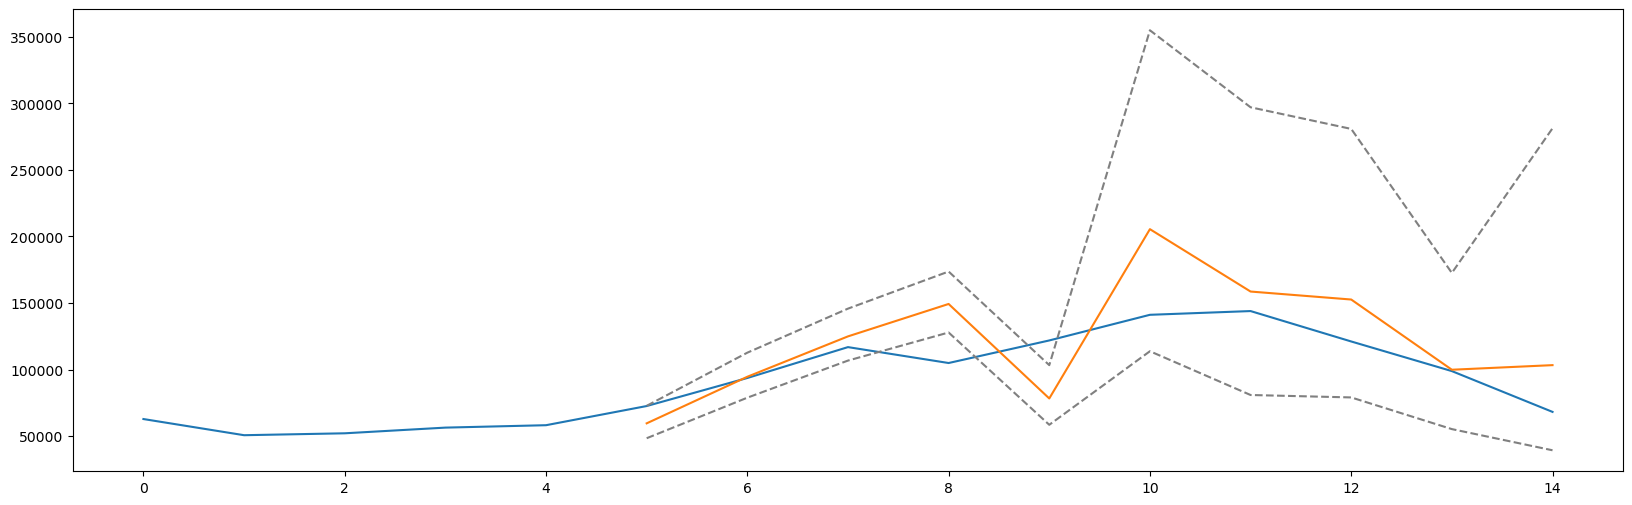

In [33]:
pis = jnp.array([result_to_pi(result) for result in results])


idx_start = df[df["date"] == first_date_start].index[0]
idx_end = df[df["date"] == date_end].index[0]

dates = pd.to_datetime(df.iloc[idx_start : idx_end + 1]["date"])

y = jnp.asarray(df.iloc[idx_start : idx_end + 1, 1:5], dtype=jnp.float64)

plt.plot(y.sum(axis=-1).reshape((-1, 7)).sum(axis=1))
plt.plot(jnp.arange(5, 15), pis[:, 1])
plt.plot(jnp.arange(5, 15), pis[:, 0], color="grey", linestyle="--")
plt.plot(jnp.arange(5, 15), pis[:, 2], color="grey", linestyle="--")